# Optimización Bayesiana

## Introducción

En el ámbito de la ciencia de datos y el aprendizaje automático, la selección de hiperparámetros desempeña un papel crucial para garantizar el desempeño óptimo de los modelos predictivos. Los hiperparámetros, a diferencia de los parámetros internos de un modelo, son configuraciones que deben definirse antes del proceso de entrenamiento y que afectan directamente la capacidad del modelo para generalizar, es decir, aprender patrones complejos y evitar problemas como el sobreajuste o el subajuste. 
Tradicionalmente, las técnicas como la búsqueda en cuadrícula (Grid Search) o la búsqueda aleatoria (Random Search) han sido ampliamente utilizadas para esta tarea. Sin embargo, su naturaleza exhaustiva o aleatoria las hace poco eficientes, especialmente en escenarios donde el espacio de búsqueda es vasto o los recursos computacionales son limitados.

La optimización bayesiana ha emergido como una metodología eficiente y efectiva para abordar el problema de la selección de hiperparámetros. Esta técnica combina principios probabilísticos y de optimización para modelar de manera iterativa el espacio de búsqueda, utilizando un enfoque basado en la exploración y explotación de las configuraciones más prometedoras. Al construir un modelo probabilístico del rendimiento del modelo en función de los hiperparámetros, la optimización bayesiana permite identificar de manera más estratégica aquellos conjuntos de hiperparámetros que maximizan o minimizan una métrica objetivo, como la pérdida logarítmica, la exactitud o cualquier otra medida de desempeño.

Este proyecto se enfoca en explorar la aplicación de la optimización bayesiana para la búsqueda de hiperparámetros en modelos de aprendizaje automático. A través de una combinación de métodos numéricos, técnicas de optimización y herramientas avanzadas como Gaussian Processes, Tree-structured Parzen Estimators (TPE) o modelos basados en redes neuronales, se busca evaluar cómo esta técnica mejora la eficiencia y el rendimiento en comparación con enfoques tradicionales. Además, se analizarán los beneficios, desafíos y limitaciones inherentes a su implementación, proporcionando un marco de referencia para la selección óptima de hiperparámetros en proyectos de machine learning y deep learning.

![Busqueda Hiperparámetros](imgs/esquema_enfoques_HPO.png)

FALTA aqui poner todo el desarrollo matematico (si les parece bien lo dejamos como un tipo articulo, yo lo paso a qmd para hacerlo sin codigo.)

## Implementación con NumPy y SciPy

En esta sección, implementaremos la función de adquisición y su optimización en NumPy y SciPy, así mismo usaremos scikit-learn para la el proceso gaussiano. Aunque tenemos una expresión analítica del objetivo de optimización `f` en el siguiente ejemplo, lo tratamos como una `Black-Box` y lo aproximamos iterativamente con un proceso gaussiano durante la optimización bayesiana. Además, las muestras extraídas de la función objetivo son ruidosas y el nivel de ruido está dado por la variable `noise`. La optimización se realiza dentro de los `límites` dados. También asumimos que existen dos muestras iniciales en `X_init` e `Y_init`.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
from bayesian_optimization_util import plot_approximation, plot_acquisition, plot_convergence
from sklearn.base import clone
from skopt import gp_minimize
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern
from skopt.space import Real
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization

In [3]:
%matplotlib inline

np.random.seed(42)
bounds = np.array([[-1.0, 2.0]])
noise = 0.2

def f(X, noise=noise):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)

X_init = np.array([[-0.9], [1.1]])
Y_init = f(X_init)

La siguiente gráfica muestra:
- La función objetivo libre de ruido
- La cantidad de ruido al representar gráficamente una gran cantidad de muestras y
- Las dos muestras iniciales

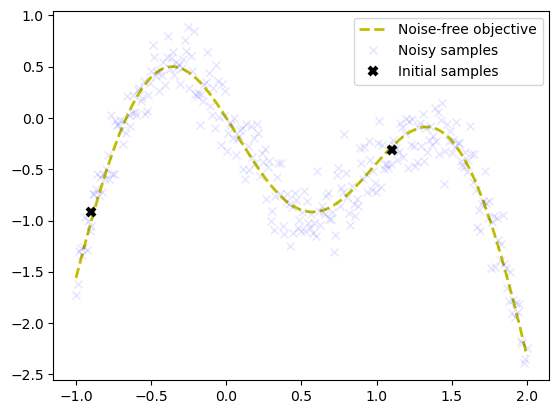

In [4]:
# Dense grid of points within bounds
np.random.seed(42)
X = np.linspace(bounds[0, 0], bounds[0, 1], 300).reshape(-1, 1)

# Noise-free objective function values at X 
Y = f(X, 0)

# Plot optimization objective with noise level 
plt.plot(X, Y, 'y--', lw=2, label='Noise-free objective')
plt.plot(X, f(X), 'bx', lw=1, alpha=0.1, label='Noisy samples')
plt.plot(X_init, Y_init, 'kx', markeredgewidth=3, label='Initial samples')
plt.legend()
plt.show()

El objetivo, es encontrar el óptimo global a la izquierda, en una pequeña cantidad de pasos. 

El siguiente paso es implementar la función de adquisición definida en la ecuación (2) como función `expected_improvement`.

In [5]:
def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    """
    Calcula la mejora esperada (Expected Improvement, EI) en los puntos X
    utilizando muestras X_sample, Y_sample y un modelo sustituto (Gaussian Process Regressor).

    Args:
        X (np.ndarray): Puntos donde calcular la EI (m x d).
        X_sample (np.ndarray): Ubicaciones de las muestras (n x d).
        Y_sample (np.ndarray): Valores de las muestras (n x 1).
        gpr (GaussianProcessRegressor): Modelo GP ajustado a las muestras.
        xi (float): Parámetro de exploración-explotación (default=0.01).

    Returns:
        np.ndarray: Valores de la función de adquisición EI en los puntos X.
    """
    # Predicción del modelo sustituto
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)

    # Asegúrate de que sigma sea unidimensional
    sigma = sigma.flatten()

    # Valor máximo de la función objetivo conocido hasta ahora
    mu_sample_opt = np.max(mu_sample)

    # Calcula la EI
    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = np.divide(imp, sigma, where=(sigma != 0))  # Evita divisiones por cero
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)

    # Establece EI a 0 donde sigma es 0
    ei[sigma == 0] = 0.0

    return ei

También necesitamos una función que proponga el siguiente punto de muestreo, calculando la ubicación del máximo de la función de adquisición. La optimización se reinicia `n_restarts` veces para evitar óptimos locales.

In [6]:
def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    """
    Propone el siguiente punto de muestreo optimizando la función de adquisición.

    Args:
        acquisition: Función de adquisición.
        X_sample: Ubicaciones de las muestras (n x d).
        Y_sample: Valores de las muestras (n x 1).
        gpr: GaussianProcessRegressor ajustado a las muestras.
        bounds: Límites del espacio de búsqueda (d x 2).
        n_restarts: Número de reinicios aleatorios para optimización global.

    Returns:
        np.ndarray: Ubicación del máximo de la función de adquisición.
    """
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None

    def min_obj(X):
        # El objetivo de minimización es la función de adquisición negativa
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr).flatten()

    # Encuentra el mejor óptimo comenzando desde puntos aleatorios diferentes
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')
        if res.fun < min_val:  # Aquí corregimos la comparación sin indexar res.fun
            min_val = res.fun
            min_x = res.x

    if min_x is None:
        raise ValueError("No se encontró un óptimo válido en propose_location.")

    return min_x.reshape(-1, 1)

Ahora tenemos todos los componentes necesarios para ejecutar la optimización bayesiana con el algoritmo descrito anteriormente. El proceso gaussiano del siguiente ejemplo está configurado con un [Matérn kernel](http://scikit-learn.org/stable/modules/gaussian_process.html#matern-kernel). El nivel de ruido conocido se configura con el parámetro `alpha`.

La optimización bayesiana, se ejecuta durante 10 iteraciones. En cada iteración, produce una fila con dos gráficos. 

El gráfico de la izquierda muestra la función objetivo sin ruido, la función sustituta, que es la media predictiva posterior de Gaussian Process, el intervalo de confianza  es de 95% de la media y las muestras ruidosas obtenidas de la función objetivo hasta el momento. 

El gráfico de la derecha muestra la función de adquisición. 

La línea discontinua vertical en ambos gráficos muestra el punto de muestreo propuesto para la siguiente iteración, que corresponde al máximo de la función de adquisición.

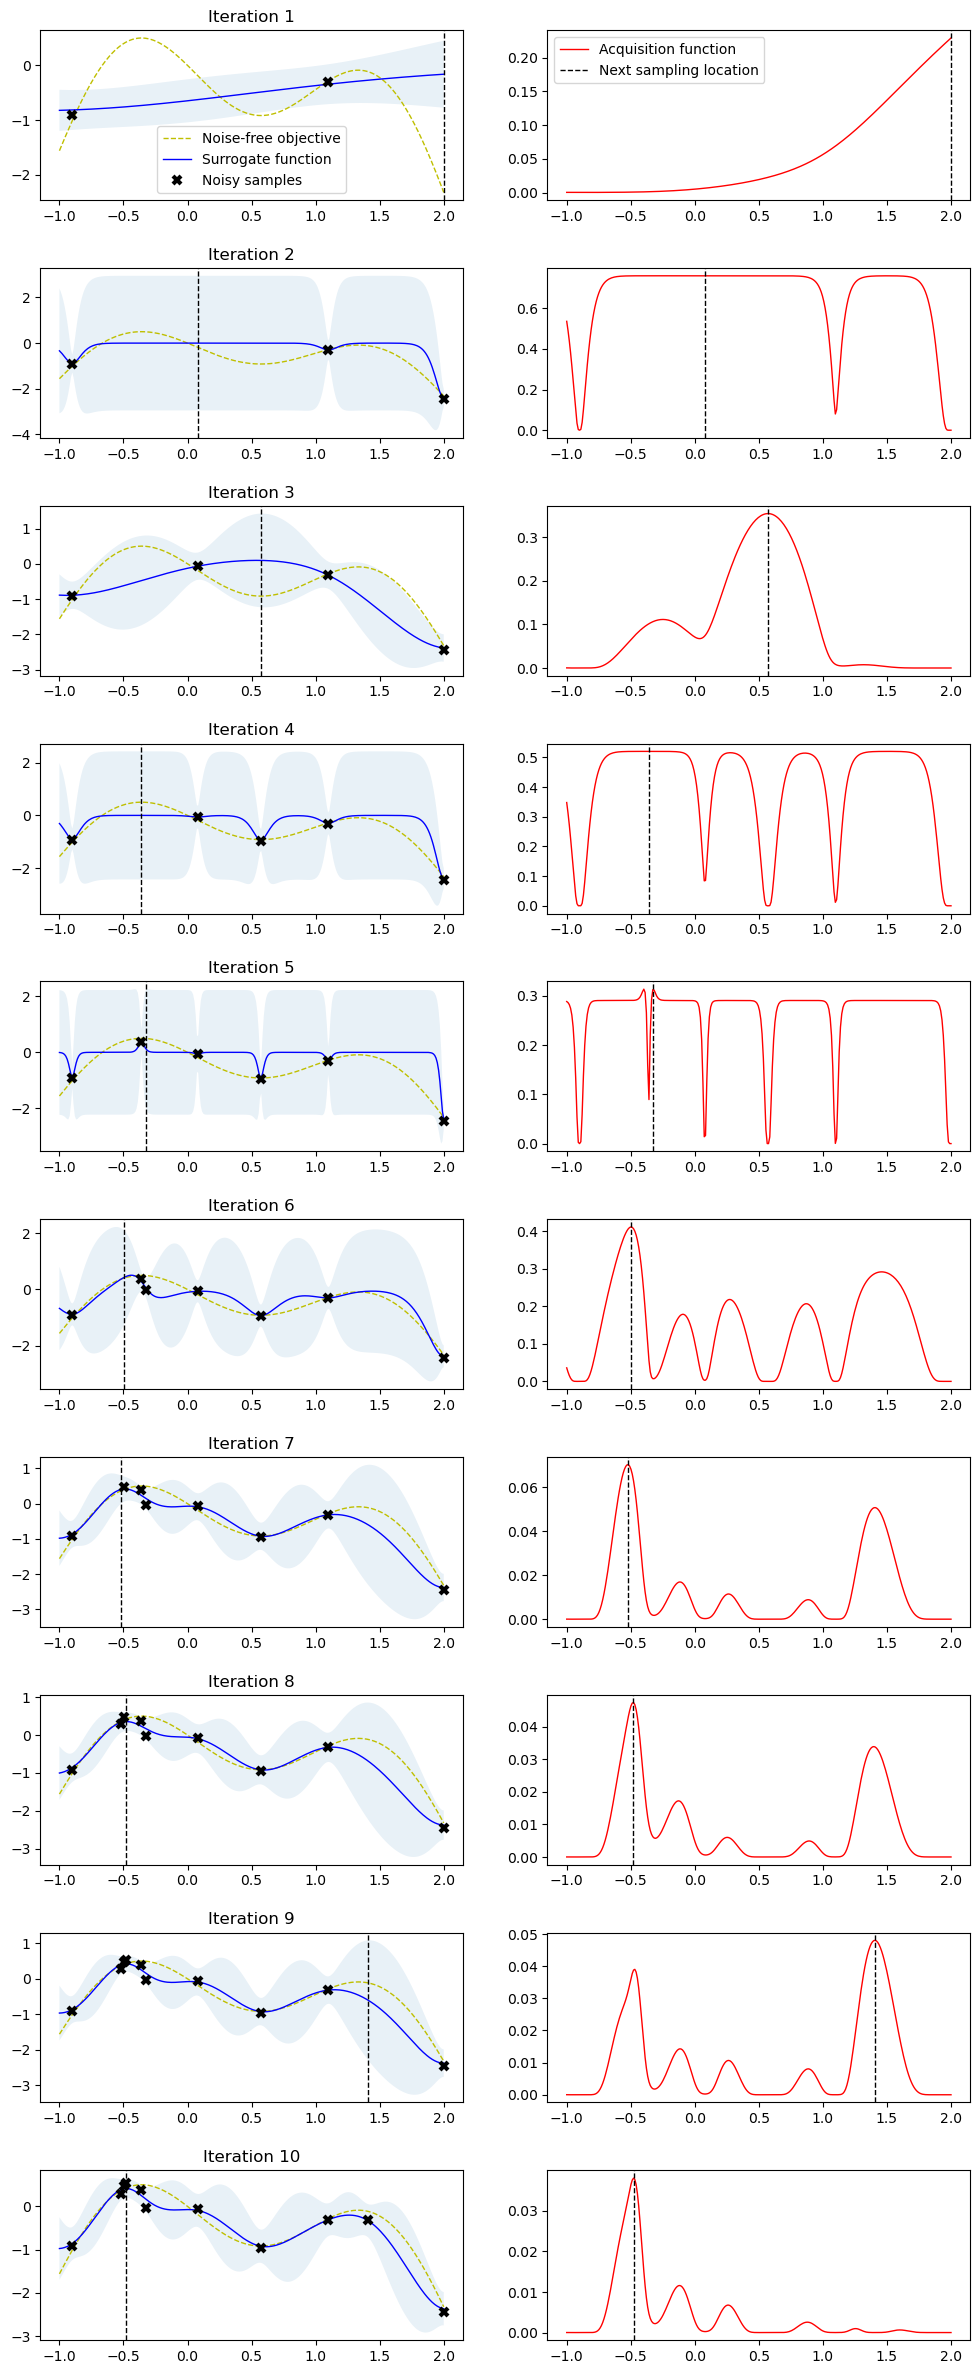

In [10]:
# Proceso gaussiano con kernel Matérn como modelo sustituto
np.random.seed(42)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
from bayesian_optimization_util import plot_approximation, plot_acquisition

# Gaussian process with Matérn kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

# Initialize samples
X_sample = X_init
Y_sample = Y_init

# Number of iterations
n_iter = 10

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
    
    # Obtain next noisy sample from the objective function
    Y_next = f(X_next, noise)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, expected_improvement(X, X_sample, Y_sample, gpr), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))


Se puede observar, cómo las dos muestras iniciales dirigen la búsqueda hacia la dirección del máximo local en el lado derecho, pero la exploración, permite que el algoritmo escape de ese óptimo local y encuentre el óptimo global en el lado izquierdo. 

Así mismo se observa también cómo las propuestas de puntos de muestreo, a menudo caen dentro de regiones de alta incertidumbre (exploración) y no solo están impulsadas por los valores más altos de la función sustituta (explotación).

Un gráfico de convergencia revela cuántas iteraciones se necesitan para encontrar un máximo y si las propuestas de puntos de muestreo se mantienen alrededor de ese máximo, es decir, convergen a pequeñas diferencias entre pasos consecutivos.

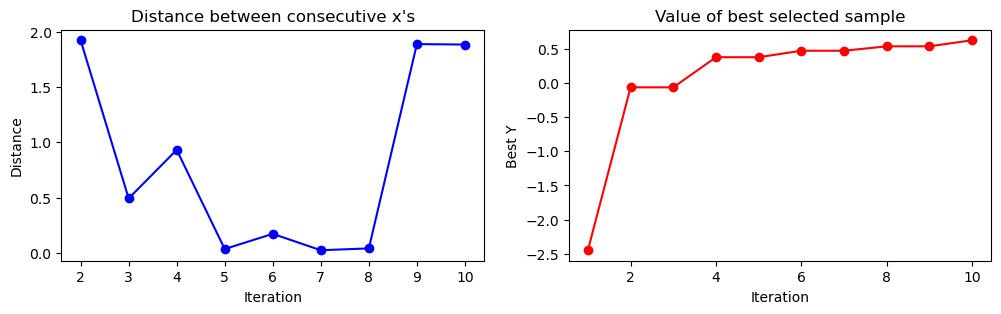

In [13]:
plot_convergence(X_sample, Y_sample)

## Bibliotecas de Optimización Bayesiana

Existen numerosas bibliotecas de optimización bayesiana y el objetivo de este análisis no es brindar una descripción general de dichas librerias, sino, de ejemplificar dos y mostrar la configuración mínima necesaria para ejecutar el ejemplo anterior.

### Scikit-optimize

[Scikit-optimize](https://scikit-optimize.github.io/) es una biblioteca para la optimización basada en modelos secuenciales que se basa en [NumPy](https://numpy.org/), [SciPy](https://scipy.org/) y [Scikit-Learn](http://scikit-learn.org/). También admite la optimización bayesiana mediante procesos gaussianos. La API está diseñada en torno a la minimización, por lo tanto, tenemos que proporcionar valores de función objetivo negativos. Los resultados obtenidos aquí difieren ligeramente de los resultados anteriores debido al comportamiento de optimización no determinista y a las diferentes muestras ruidosas extraídas de la función objetivo.

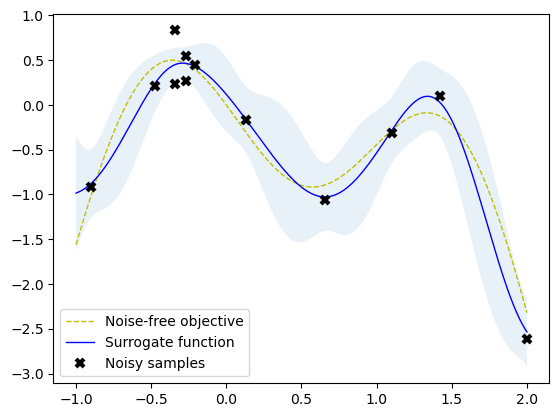

In [15]:
from sklearn.base import clone
from skopt import gp_minimize
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern
from skopt.space import Real

# Define bounds as Real to avoid warnings
bounds = [Real(-1.0, 2.0)]

# Use custom kernel and estimator to match previous example
np.random.seed(42)
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

# Perform Bayesian optimization
r = gp_minimize(lambda x: -f(np.array(x))[0], 
                bounds,               # Define bounds explicitly
                base_estimator=gpr,   # Use custom GP estimator
                acq_func='EI',        # Expected improvement
                xi=0.01,              # Exploitation-exploration trade-off
                n_calls=10,           # Number of iterations
                n_random_starts=0,    # Initial samples are provided
                x0=X_init.tolist(),   # Initial samples
                y0=-Y_init.ravel())   # Initial values

# Fit GP model to samples for plotting results
gpr.fit(r.x_iters, -r.func_vals)

# Plot the fitted model and the noisy samples
plot_approximation(gpr, X, Y, r.x_iters, -r.func_vals, show_legend=True)



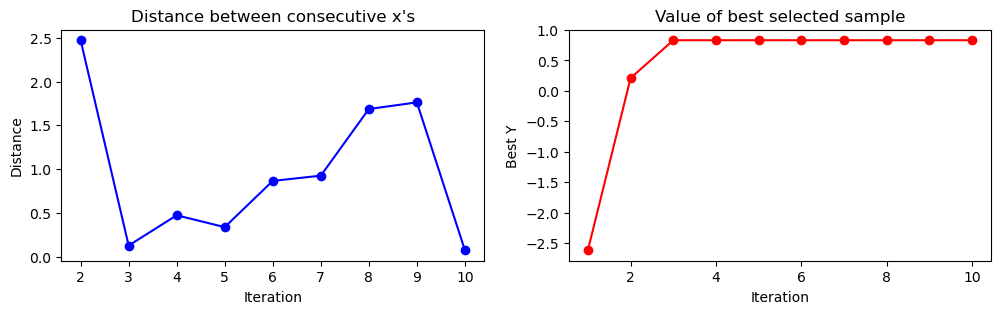

In [16]:
plot_convergence(np.array(r.x_iters), -r.func_vals)

## GPyOpt

[GPyOpt](http://sheffieldml.github.io/GPyOpt/) es una biblioteca de optimización bayesiana basada en [GPy](https://sheffieldml.github.io/GPy/). El nivel de abstracción de la API, es comparable al de scikit-optimize. 
La API `BayesianOptimization` proporciona un parámetro `maximize` para configurar si la función objetivo se maximizará o minimizará (predeterminado). En la versión 1.2.1, esto parece ignorarse al proporcionar muestras iniciales, por lo que tenemos que negar sus valores objetivo manualmente en el siguiente ejemplo. Además, los métodos integrados `plot_acquisition` y `plot_convergence` muestran el resultado de la minimización en cualquier caso. Nuevamente, los resultados obtenidos aquí difieren ligeramente de los resultados anteriores debido al comportamiento de optimización no determinista y a las diferentes muestras ruidosas extraídas de la función objetivo.

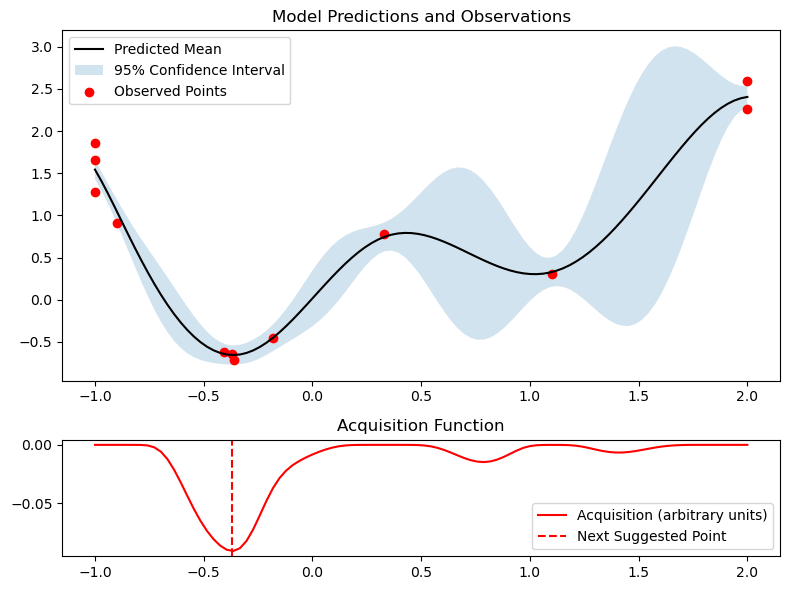

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Generar datos para la función de adquisición y el modelo
domain = bds[0]['domain']
x_grid = np.linspace(domain[0], domain[1], 100).reshape(-1, 1)
acquisition_function = optimizer.acquisition.acquisition_function
acq_values = acquisition_function(x_grid)

# Predicción del modelo
mu, sigma = optimizer.model.model.predict(x_grid)

# Crear la figura con subgráficas
fig, axs = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={'height_ratios': [3, 1]})

# Gráfica superior: Modelo Gaussiano y observaciones
axs[0].plot(x_grid, mu, 'k-', label="Predicted Mean")
axs[0].fill_between(x_grid.ravel(),
                    mu.ravel() - 1.96 * sigma.ravel(),
                    mu.ravel() + 1.96 * sigma.ravel(),
                    alpha=0.2, label="95% Confidence Interval")
axs[0].scatter(optimizer.X, optimizer.Y, color='red', label="Observed Points")
axs[0].set_title("Model Predictions and Observations")
axs[0].legend()

# Gráfica inferior: Función de adquisición
axs[1].plot(x_grid, acq_values, 'r-', label="Acquisition (arbitrary units)")
axs[1].axvline(x=optimizer.suggest_next_locations()[0][0], color='red', linestyle='--', label="Next Suggested Point")
axs[1].set_title("Acquisition Function")
axs[1].legend()

# Ajustar diseño y mostrar
plt.tight_layout()
plt.show()

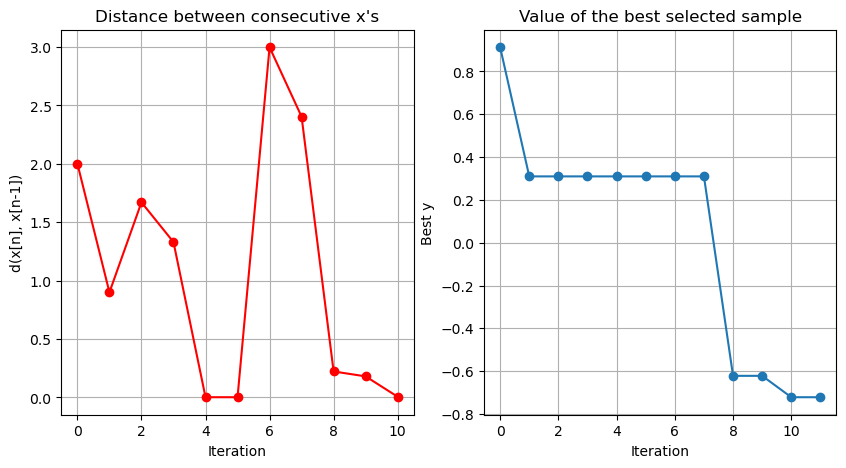

In [21]:
optimizer.plot_convergence()

## Aplicación

En esta sección demuestraremos cómo optimizar los hiperparámetros de un `XGBRegressor` con GPyOpt y cómo se compara el rendimiento de la optimización bayesiana con la búsqueda aleatoria. `XGBRegressor` es parte de [XGBoost](https://xgboost.readthedocs.io/), una biblioteca de aumento de gradiente flexible y escalable. `XGBRegressor` implementa la API de estimador de scikit-learn y se puede aplicar a problemas de regresión. La regresión se realiza en un pequeño [conjunto de datos de ejemplo](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes) que es parte de scikit-learn.

In [22]:
from sklearn import datasets
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

from scipy.stats import uniform
from xgboost import XGBRegressor

# Load the diabetes dataset (for regression)
X, Y = datasets.load_diabetes(return_X_y=True)

# Instantiate an XGBRegressor with default hyperparameter settings
xgb = XGBRegressor()

# and compute a baseline to beat with hyperparameter optimization 
baseline = cross_val_score(xgb, X, Y, scoring='neg_mean_squared_error').mean()

### Ajuste de hiperparámetros con búsqueda aleatoria

Para el ajuste de hiperparámetros con búsqueda aleatoria, utilizamos `RandomSearchCV` de scikit-learn y calculamos una puntuación de validación cruzada para cada punto seleccionado aleatoriamente en el espacio de hiperparámetros. Los resultados se analizarán a continuación:

In [23]:
# Hyperparameters to tune and their ranges
param_dist = {"learning_rate": uniform(0, 1),
              "gamma": uniform(0, 5),
              "max_depth": range(1,50),
              "n_estimators": range(1,300),
              "min_child_weight": range(1,10)}

rs = RandomizedSearchCV(xgb, param_distributions=param_dist, 
                        scoring='neg_mean_squared_error', n_iter=25)

# Run random search for 25 iterations
rs.fit(X, Y);

### Ajuste de hiperparámetros con optimización bayesiana

Para ajustar los hiperparámetros con optimización bayesiana, implementamos una función objetivo `cv_score` que toma los hiperparámetros como entrada y devuelve una puntuación de validación cruzada. Aquí, asumimos que la validación cruzada en un punto determinado en el espacio de hiperparámetros es determinista y, por lo tanto, establecemos el parámetro `exact_feval` de `BayesianOptimization` en `True`. Dependiendo del ajuste del modelo y los detalles de la validación cruzada, esto podría no ser el caso, pero lo ignoraremos aquí.

In [24]:
bds = [{'name': 'learning_rate', 'type': 'continuous', 'domain': (0, 1)},
        {'name': 'gamma', 'type': 'continuous', 'domain': (0, 5)},
        {'name': 'max_depth', 'type': 'discrete', 'domain': (1, 50)},
        {'name': 'n_estimators', 'type': 'discrete', 'domain': (1, 300)},
        {'name': 'min_child_weight', 'type': 'discrete', 'domain': (1, 10)}]

# Optimization objective 
def cv_score(parameters):
    parameters = parameters[0]
    score = cross_val_score(
                XGBRegressor(learning_rate=parameters[0],
                              gamma=int(parameters[1]),
                              max_depth=int(parameters[2]),
                              n_estimators=int(parameters[3]),
                              min_child_weight = parameters[4]), 
                X, Y, scoring='neg_mean_squared_error').mean()
    score = np.array(score)
    return score

optimizer = BayesianOptimization(f=cv_score, 
                                 domain=bds,
                                 model_type='GP',
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.05,
                                 exact_feval=True, 
                                 maximize=True)

# Only 20 iterations because we have 5 initial random points
optimizer.run_optimization(max_iter=20)

In [26]:
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
import numpy as np

# Define los dominios de búsqueda (bounds)
search_space = [
    Real(0, 1, name='learning_rate'),               # learning_rate
    Real(0, 5, name='gamma'),                       # gamma
    Integer(1, 50, name='max_depth'),               # max_depth
    Integer(1, 300, name='n_estimators'),           # n_estimators
    Integer(1, 10, name='min_child_weight')         # min_child_weight
]

# Función objetivo para minimizar (se negará el MSE para que sea una minimización)
@use_named_args(search_space)
def cv_score(learning_rate, gamma, max_depth, n_estimators, min_child_weight):
    model = XGBRegressor(
        learning_rate=learning_rate,
        gamma=gamma,
        max_depth=max_depth,
        n_estimators=n_estimators,
        min_child_weight=min_child_weight
    )
    score = cross_val_score(model, X, Y, scoring='neg_mean_squared_error').mean()
    return -score  # Negamos el puntaje para minimizar

# Ejecutar la optimización bayesiana
result = gp_minimize(
    func=cv_score,                 # Función objetivo
    dimensions=search_space,       # Espacio de búsqueda
    acq_func='EI',                 # Expected Improvement
    n_calls=20,                    # Número de iteraciones
    n_initial_points=5,            # Puntos iniciales aleatorios
    random_state=42                # Reproducibilidad
)

# Resultados de la optimización
print("Best parameters:")
print({dim.name: val for dim, val in zip(search_space, result.x)})
print("Best negative MSE:", result.fun)


Best parameters:
{'learning_rate': 0.2890469047998405, 'gamma': 2.7630803050331583, 'max_depth': 1, 'n_estimators': 54, 'min_child_weight': 9}
Best negative MSE: 3159.497536251517


### Resultados

En promedio, la optimización bayesiana encuentra un óptimo mejor en una menor cantidad de pasos que la búsqueda aleatoria y supera la línea base en casi todas las ejecuciones. Esta tendencia se vuelve aún más prominente en espacios de búsqueda de dimensiones superiores. Aquí, el espacio de búsqueda es de cinco dimensiones, lo cual es bastante bajo para obtener un beneficio sustancial de la optimización bayesiana. Una ventaja de la búsqueda aleatoria es que es fácil de paralelizar. La paralelización de la optimización bayesiana es mucho más difícil y está sujeta a investigación.

Baseline neg. MSE = 4000.18
Random search neg. MSE = -3935.27
Bayesian optimization skopt neg. MSE = -3159.50


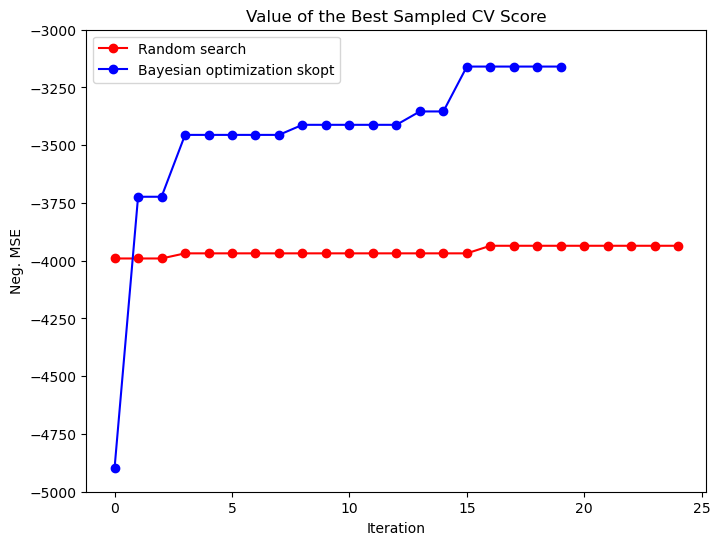

In [29]:
# Máximos acumulados para Random Search
# Asegúrate de que 'mean_test_score' esté disponible en tu búsqueda aleatoria
if 'mean_test_score' in rs.cv_results_:
    y_rs = np.maximum.accumulate(rs.cv_results_['mean_test_score'])
else:
    y_rs = None

# Máximos acumulados para la optimización bayesiana
y_bo = np.maximum.accumulate(-np.array(result.func_vals))

# Imprimir los resultados
baseline = -np.mean(cross_val_score(XGBRegressor(), X, Y, scoring='neg_mean_squared_error'))
print(f'Baseline neg. MSE = {baseline:.2f}')
if y_rs is not None:
    print(f'Random search neg. MSE = {y_rs[-1]:.2f}')
print(f'Bayesian optimization skopt neg. MSE = {y_bo[-1]:.2f}')

# Graficar los resultados
plt.figure(figsize=(8, 6))
if y_rs is not None:
    plt.plot(y_rs, 'ro-', label='Random search')
plt.plot(y_bo, 'bo-', label='Bayesian optimization skopt')
plt.xlabel('Iteration')
plt.ylabel('Neg. MSE')
plt.ylim(-5000, -3000)  # Ajusta estos límites según tu problema
plt.title('Value of the Best Sampled CV Score')
plt.legend()
plt.show()


Baseline neg. MSE = 4000.18
Random search neg. MSE = -3935.27
Bayesian optimization GPyOpt neg. MSE = -3182.70


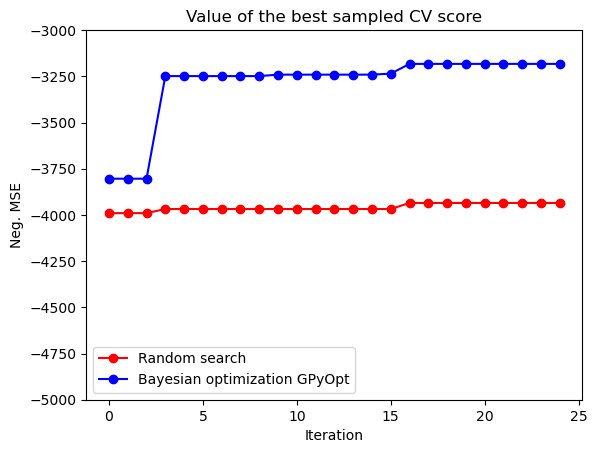

In [28]:
y_rs = np.maximum.accumulate(rs.cv_results_['mean_test_score'])
y_bo = np.maximum.accumulate(-optimizer.Y).ravel()

print(f'Baseline neg. MSE = {baseline:.2f}')
print(f'Random search neg. MSE = {y_rs[-1]:.2f}')
print(f'Bayesian optimization GPyOpt neg. MSE = {y_bo[-1]:.2f}')

plt.plot(y_rs, 'ro-', label='Random search')
plt.plot(y_bo, 'bo-', label='Bayesian optimization GPyOpt')
plt.xlabel('Iteration')
plt.ylabel('Neg. MSE')
plt.ylim(-5000, -3000)
plt.title('Value of the best sampled CV score');
plt.legend();